In [10]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

from collections import Counter 

%matplotlib inline

In [6]:
trips = pd.read_csv('201508_trip_data.csv')

In [7]:
trips.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


# 1. Which Bike Station saw the most use over September 2014-2015?

San Francisco Caltrain (Townsend at 4th)

bikes: 26304

In [8]:
trips.groupby('Start Station')['Bike #'].count().sort_values()[::-1][:10]

Start Station
San Francisco Caltrain (Townsend at 4th)         26304
San Francisco Caltrain 2 (330 Townsend)          21758
Harry Bridges Plaza (Ferry Building)             17255
Temporary Transbay Terminal (Howard at Beale)    14436
Embarcadero at Sansome                           14158
2nd at Townsend                                  14026
Townsend at 7th                                  13752
Steuart at Market                                13687
Market at 10th                                   11885
Market at Sansome                                11431
Name: Bike #, dtype: int64

In [13]:
Counter(trips['Bike #'].values).most_common(10)

[(878, 1121),
 (392, 1102),
 (489, 1101),
 (463, 1085),
 (532, 1074),
 (558, 1071),
 (306, 1060),
 (29, 1057),
 (66, 1053),
 (589, 1052)]

# 2. Are Customers or Subscribers More Likely to make a round trip?

In [82]:
trip['Round_Trip'] = [1 if j == i else 0 for i,j in zip(trips['Start Station'],trips['End Station']) ]

# counting round trips made for anyone 

In [84]:
len(trip['Round_Trip'])

354152

In [86]:
round_trip = trips[trips['Round_Trip']==1]

In [87]:
round_trip.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,hr,date,dayofweek,month,Round_Trip
162,913212,73,2015-08-31 18:39:00,5th at Howard,57,8/31/2015 18:40,5th at Howard,57,456,Subscriber,94107,19,2015-08-31,1,8,1
163,913211,7558,2015-08-31 18:38:00,Embarcadero at Sansome,60,8/31/2015 20:44,Embarcadero at Sansome,60,385,Customer,34,19,2015-08-31,1,8,1
164,913210,7472,2015-08-31 18:38:00,Embarcadero at Sansome,60,8/31/2015 20:43,Embarcadero at Sansome,60,585,Customer,34,19,2015-08-31,1,8,1
174,913198,353,2015-08-31 18:34:00,Townsend at 7th,65,8/31/2015 18:40,Townsend at 7th,65,370,Subscriber,94118,19,2015-08-31,1,8,1
432,912838,631,2015-08-31 17:02:00,University and Emerson,35,8/31/2015 17:13,University and Emerson,35,253,Customer,6907,18,2015-08-31,1,8,1


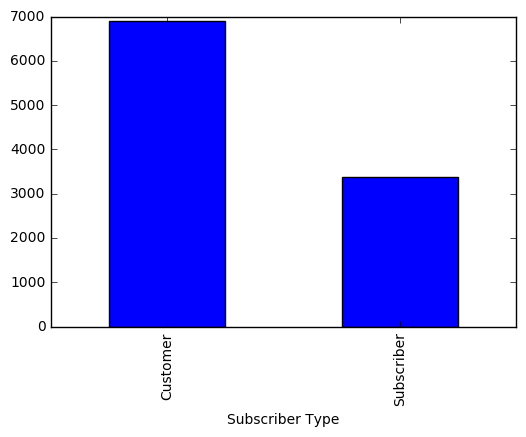

In [111]:
round_trip.groupby('Subscriber Type').apply(len).plot(kind = "bar");

Initially the data appears that customers are more likely to do round trips.....

# Two Sample Hypothesis Testing

In [138]:
Customer = list(round_trip['Subscriber Type']).count('Customer')
Subscriber  = list(round_trip['Subscriber Type']).count('Subscriber')
Customer_total = list(trips['Subscriber Type']).count('Customer')
Subscriber_total = list(trips['Subscriber Type']).count('Subscriber')

* Test statistic  

$ t_{stat} = \frac{(\hat{p}_1 - \hat{p}_2)}{\sqrt{\hat{p}(1 - \hat{p}) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)}} $

where 

$ \hat{p} = \frac{n_1 \hat{p}_1 + n_2 \hat{p}_2}{n_1 + n_2} $

H_0 = the two proportions of customer and subscriber are the same
H_a = the two proportions of customer and subscriber are not the same

In [143]:
x_1 = float(Customer)
x_2 = float(Subscriber)
n_1 = float(Customer_total)
n_2 = float(Subscriber_total)
p_1 = x_1 / n_1
p_2 = x_2 / n_2
p_t = (x_1 + x_2) / (n_1 + n_2)

print "P1", p_1
print "P2", p_2
print "P_total", p_t

t_stat = (p_2- p_1) / np.sqrt(p_t * (1 - p_t) * (1. / n_1 + 1. / n_2))
print 't_stat' , t_stat
print ss.norm.cdf(t_stat)

P1 0.156981905087
P2 0.0108923753373
P_total 0.0290157898304
t_stat -170.741491834
0.0


There is strong evidence to suggest that the proportion between Customers and Subscribers are different.  Therefore, we reject the Null Hypothesis.  

# 3.  Daily Graph of trips over the Entire Period

In [19]:
def read_trips_and_preprocess(filename):
    
    # Read in file
    trips = pd.read_csv(filename, parse_dates = ['Start Date'])
    start_time = trips['Start Date']
    
    # Get hour, date, dayofweek
    hr = start_time.apply(lambda x: x.hour) + 1
    date = start_time.apply(lambda x: x.date())
    dayofweek = start_time.apply(lambda x: x.dayofweek + 1) # Monday = 1, Sunday = 7
    month = start_time.apply(lambda x: x.month)
    
    trips['hr'] = hr
    trips['date'] = date
    trips['dayofweek'] = dayofweek
    trips['month'] = month
    
    return trips
trips = read_trips_and_preprocess('201508_trip_data.csv')    

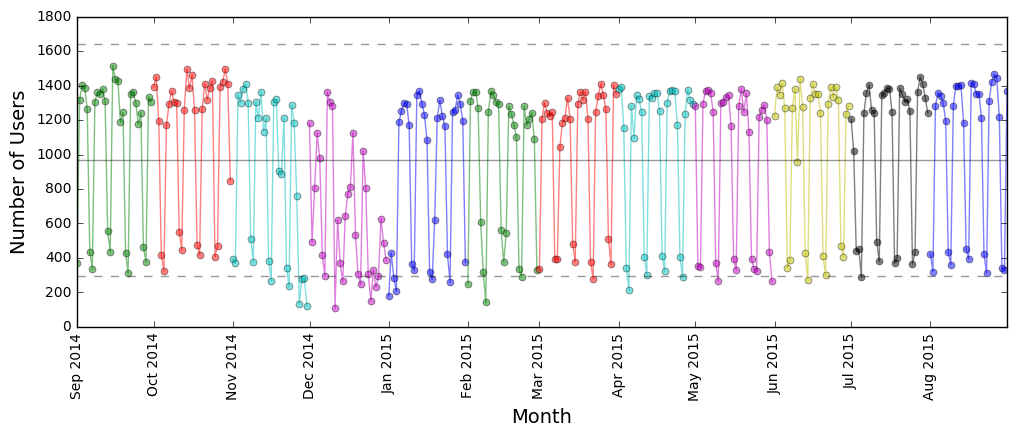

In [68]:
def mth_plot(n):
    mth = trips[trips['month'] == n]
    mth_cnt = mth.groupby('date').apply(len)
    mth_cnt.plot(marker = 'o', markersize = 5, alpha = 0.5, rot = 90)
    
fig = plt.figure(figsize = (12, 4))
mth_plot(1)
mth_plot(2)
mth_plot(3)
mth_plot(4)
mth_plot(5)
mth_plot(6)
mth_plot(7)
mth_plot(8)
mth_plot(9)
mth_plot(10)
mth_plot(11)
mth_plot(12)



plt.ylabel("Number of Users", fontsize = 14)
plt.xlabel("Month", fontsize = 14)
count_on_each_day = trips.groupby('date').apply(len)
mean_activity = count_on_each_day.mean()
upper_std = mean_activity + 1.5 * np.std(count_on_each_day)
lower_std = mean_activity - 1.5 * np.std(count_on_each_day)
plt.axhline(upper_std, linestyle = '--', c = 'black', alpha = 0.4)
plt.axhline(lower_std, linestyle = '--', c = 'black', alpha = 0.4)
plt.axhline(mean_activity, c = "black", alpha = 0.4)
plt.show()

In [83]:
trips.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,hr,date,dayofweek,month,Round_Trip
0,913460,765,2015-08-31 23:26:00,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,24,2015-08-31,1,8,0
1,913459,1036,2015-08-31 23:11:00,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032,24,2015-08-31,1,8,0
2,913455,307,2015-08-31 23:13:00,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107,24,2015-08-31,1,8,0
3,913454,409,2015-08-31 23:10:00,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113,24,2015-08-31,1,8,0
4,913453,789,2015-08-31 23:09:00,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069,24,2015-08-31,1,8,0


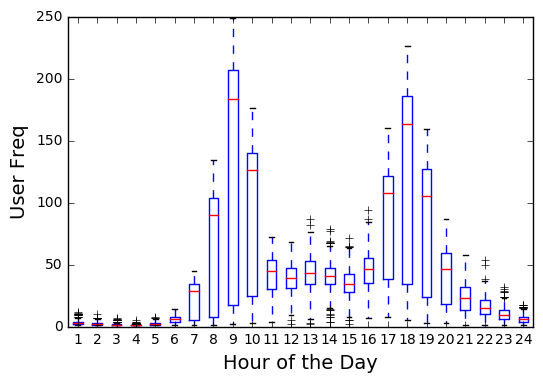

In [22]:
def plot_basic_trends(df):
    start_time = df['Start Date']
    hr = start_time.apply(lambda x: x.hour) + 1
    date = start_time.apply(lambda x: x.date())
    dayofweek = start_time.apply(lambda x: x.dayofweek + 1) # Monday = 1, Sunday = 7
    hr = df['hr']
    date = df['date']
    hr_cnt = df.groupby(['date', 'hr']).apply(len).reset_index()
    gpby = hr_cnt.groupby('hr')
    lst = [gpby.get_group(hr)[0] for hr in gpby.groups]
    plt.boxplot(lst)
    plt.xlabel('Hour of the Day', fontsize = 14)
    plt.ylabel('User Freq', fontsize = 14)
    
plot_basic_trends(trips)

# 4. Visual of Weekday vs Weekend Trips

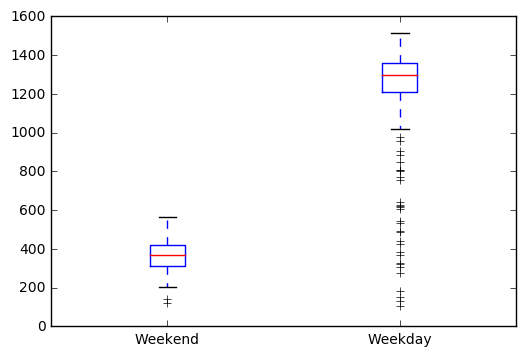

In [27]:
cnt = trips.groupby(['date', 'dayofweek']).apply(len).reset_index()

weekend = cnt[cnt['dayofweek'] > 5][0].values
weekday = cnt[cnt['dayofweek'] <= 5][0].values
plt.boxplot([weekend, weekday]);
plt.xticks([1,2],['Weekend','Weekday'])
plt.show()

The Boxplot shows that there is a significant drop in ridership over the weekends as opposed to weekday

# 5. Business Ramifications of my findings

Ridership is conistent, but there is a big drop during the Dec-Jan months

Boxplot by 24 hour period shows what hours people use ridership the most

Boxplot shows that Weekdays are busier.

The usage times could be used to allocation resources to monitor and maintain Bike Stations

Any time of maintainence would be during the hours that people are low.

Less monitoring are times when people are not there.

We can treat the customers and subscribers different groups seperately when it comes to marketing based on their needs and patterns. 